# Fine Tuning Wav2Vec2 
This notebook fine-tunes a pre-trained Wav2Vec2 model on the Common Voice dataset. The model is fine-tuned using PyTorch on Google Colab. 

There should not be any need to install any packages as these are already installed in the Colab environment. However, if you are running this notebook in a different environment, you may need to install the below packages. 

In [1]:
import os

import pickle
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import matplotlib.pyplot as plt

# Data Loading and Preprocessing

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load csv file
df = pd.read_csv('/content/drive/Othercomputers/MyMac/10000-sample-training-data/cv-valid-train.csv', usecols=[0, 1])
df.head()

In [ ]:
# Train-Test Split
train_data, valid_data = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Load data

def load_audio_and_transcription(row, target_sample_rate=16000):
    """
    Load an audio file and its transcription.

    Args:
        row (pd.Series): A row from the DataFrame containing 'filename' and 'transcription'.
        target_sample_rate (int): The sample rate to resample audio to.

    Returns:
        waveform (Tensor): The preprocessed audio waveform.
        transcription (str): The corresponding transcription.
    """
    audio_path = os.path.join('/content/drive/Othercomputers/MyMac/10000-sample-training-data/cv-valid-train/', row['filename'])
    transcription = row['text']

    # Load the audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Resample if necessary
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    return waveform, transcription


# Load training data
train_waveforms = []
train_transcriptions = []

for _, row in train_data.iterrows():
    waveform, transcription = load_audio_and_transcription(row)
    train_waveforms.append(waveform)
    train_transcriptions.append(transcription)

# Load validation data
valid_waveforms = []
valid_transcriptions = []

for _, row in valid_data.iterrows():
    waveform, transcription = load_audio_and_transcription(row)
    valid_waveforms.append(waveform)
    valid_transcriptions.append(transcription)

We will use Pickle to save the preprocessed data offline so that we don't need to repeat the preprocessing steps every time we run the notebook.

In [ ]:
# Save data offline
def save_preprocessed_data(data, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

# Save training data
save_preprocessed_data((train_waveforms, train_transcriptions), '/content/drive/Othercomputers/MyMac/10000-sample-training-data/processed-data/preprocessed_train_data.pkl')

# Save validation data
save_preprocessed_data((valid_waveforms, valid_transcriptions), '/content/drive/Othercomputers/MyMac/10000-sample-training-data/processed-data/preprocessed_valid_data.pkl')

If you have previously run this notebook, you can skip the earlier steps and load the preprocessed data directly.

In [ ]:
# Load offline data
def load_preprocessed_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Load training data
train_waveforms, train_transcriptions = load_preprocessed_data('/content/drive/Othercomputers/MyMac/10000-sample-training-data/processed-data/preprocessed_train_data.pkl')

# Load validation data
valid_waveforms, valid_transcriptions = load_preprocessed_data('/content/drive/Othercomputers/MyMac/10000-sample-training-data/processed-data/preprocessed_valid_data.pkl')

In [ ]:
# Load the pre-trained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

cuda


In [5]:
def collate_fn(batch):
    """
    Pads input sequences in a batch to the maximum sequence length.
    Args:
        batch (list of tuples): Each tuple contains (input_values, labels).
    Returns:
        Padded batch of input_values and labels.
    """
    input_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad input_values to the maximum length
    input_values = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True, padding_value=0)

    # Pad labels to the maximum length
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)  # -100 is ignored in CTC loss

    return input_values, labels

We will define a AudioDataset Class so that we can batch the data for training. 

In [6]:
class AudioDataset(Dataset):
    def __init__(self, waveforms, transcriptions, processor, target_sample_rate=16000):
        self.waveforms = waveforms
        self.transcriptions = transcriptions
        self.processor = processor
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.waveforms)

    def __getitem__(self, idx):
        waveform = self.waveforms[idx]

        # Convert to mono if needed
        if waveform.dim() > 1:
            waveform = waveform.mean(dim=0)

        inputs = self.processor(
            waveform.numpy(),
            sampling_rate=self.target_sample_rate,
            return_tensors="pt",
            padding=True
        )

        # Tokenize transcriptions
        labels = self.processor.tokenizer(
            self.transcriptions[idx],
            padding=True,
            return_tensors="pt"
        ).input_ids.squeeze(0)

        return inputs.input_values.squeeze(0), labels

In [ ]:
# Preprocess transcriptions to use the separator that Wav2Vec2 recognizes
train_transcriptions = [t.upper().replace(" ", "|") for t in train_transcriptions]
valid_transcriptions = [t.upper().replace(" ", "|") for t in valid_transcriptions]

In [ ]:
# Create the dataset using the AudioDataset Class
train_dataset = AudioDataset(train_waveforms, train_transcriptions, processor)
valid_dataset = AudioDataset(valid_waveforms, valid_transcriptions, processor)

# Define DataLoader with increased batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, collate_fn=collate_fn)

# Model Training

Epoch 1, Training Loss: 157.0492024230957, Validation Loss: 76.62176441733043
Epoch 2, Training Loss: 119.02899622453963, Validation Loss: 70.40035627539953
Epoch 3, Training Loss: 110.29234265681676, Validation Loss: 71.1531212053299
Epoch 4, Training Loss: 100.97866914367675, Validation Loss: 68.52921194442114
Epoch 5, Training Loss: 91.9150402733939, Validation Loss: 67.88583743317922
Model and processor saved at /content/drive/Othercomputers/MyMac/10000-sample-training-data/models/wav2vec2-large-960h-cv/epoch_5
Epoch 6, Training Loss: 87.22547406387329, Validation Loss: 73.72513183999061
Epoch 7, Training Loss: 83.24067439488002, Validation Loss: 73.07345702203115
Epoch 8, Training Loss: 80.96607233973911, Validation Loss: 76.59522462991873
Epoch 9, Training Loss: 77.7382122366769, Validation Loss: 66.80087010773023
Epoch 10, Training Loss: 74.3768811329433, Validation Loss: 76.77385528556506
Model and processor saved at /content/drive/Othercomputers/MyMac/10000-sample-training-dat

ValueError: x and y must have same first dimension, but have shapes (30,) and (20,)

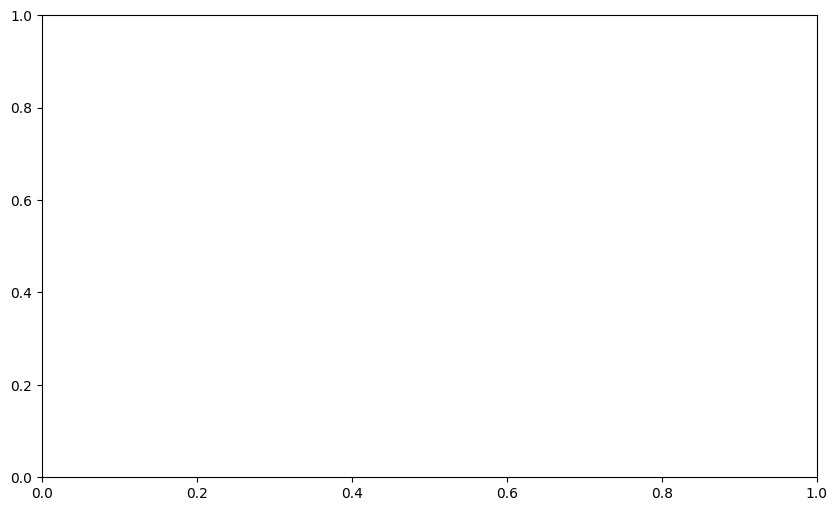

In [ ]:
# Initialize lists to store loss values
train_losses = []
val_losses = []

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Directory to save models
base_save_path = "/content/drive/Othercomputers/MyMac/10000-sample-training-data/models/wav2vec2-large-960h-cv"

# Early stop
patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

# Training loop
num_epochs = 30
save_interval = 5

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        train_inputs, train_labels = batch
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        optimizer.zero_grad()
        outputs = model(train_inputs, labels=train_labels)
        train_loss = outputs.loss

        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            valid_inputs, valid_labels = batch
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)

            val_outputs = model(valid_inputs, labels=valid_labels)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

    val_losses.append(total_val_loss / len(valid_loader))

    print(f"Epoch {epoch + 1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Save the model and processor after x epoch
    if (epoch + 1) % save_interval == 0:
        epoch_save_path = os.path.join(base_save_path, f"epoch_{epoch + 1}")
        os.makedirs(epoch_save_path, exist_ok=True)
        model.save_pretrained(epoch_save_path)
        processor.save_pretrained(epoch_save_path)
        print(f"Model and processor saved at {epoch_save_path}")

    # Early stop logic
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

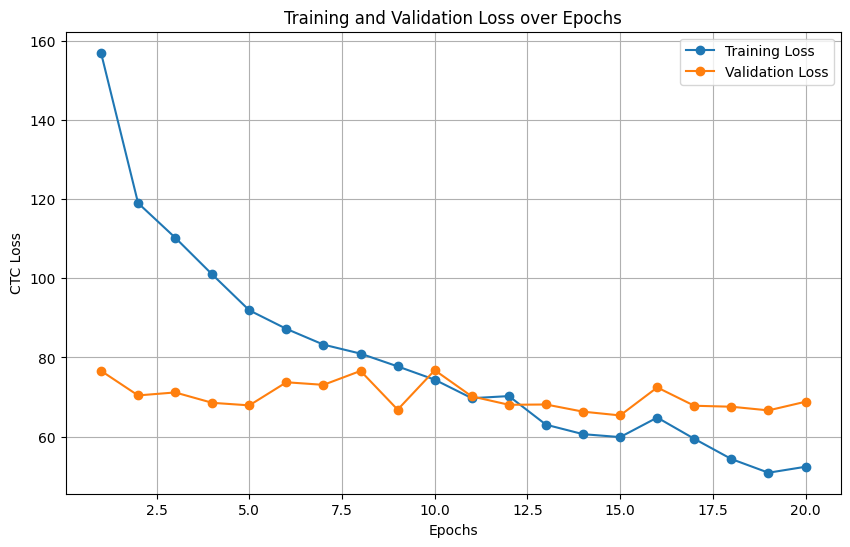

In [10]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
# Use len(train_losses) to ensure the x-axis range matches the number of epochs actually trained
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('CTC Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Finetuning Results
- Early stop was triggered after 20 epochs. We can see that after epoch 12, the model had started to overfit. 
- The training loss steadily decreases after each epoch. 
- The validation loss is relatively stable, with some fluctutation between the epochs. Furthermore, the validation loss does not decrease much. THis indicates that the model performance on unseen data does not vary significantly.  

#### Chosen Model
As we saved the checkpoints every 5 epochs, we will choose the model at epoch 15, since it only just started to overfit and it still has a low validation loss.

#### Future Work
We are are limited in time and compute, if there is future opportunity to train the model again, we could try the following:
- Increase the regularization used (e.g. higher weight decay or introduce dropout)
- Implement learning rate scheduling to optimize the loss convergence
- Try different learning rate values
- Use a larger dataset for training (we are only using 5% of the data available)

## Save Model if Required
The model is already saved during the training process. However, if you need to save the last checkpoint, you can run the code below. 

In [ ]:
# Save the model

# Save model in a directory compatible with from_pretrained
model_save_path = "/content/drive/MyDrive/HTX-Assessment/models/wav2vec2-large-960h-cv"

# Save model and configuration
model.save_pretrained(model_save_path)

# Save processor (tokenizer and feature extractor)
processor.save_pretrained(model_save_path)

# Task 3C
Here, we will use the fine-tuned model to transcribe the audio files in the test set. We will then evaluate the model using the WER and CER metric.

In [3]:
import pandas as pd
from jiwer import wer, cer

We can reuse the cv-decode.py script to decode the audio files. Remember to change the model and processor path to the fine-tuned model and processor.

In [1]:
# Use cv-decode.py to transcribe the audio using the fine-tuned model
!python ../asr/cv-decode.py ../data/common_voice/cv-valid-test.csv ../data/common_voice/cv-valid-test/ ../asr-train/transcribed_data-ft.csv

Transcriptions have been added to the CSV file.


In [7]:
# Load your CSV file
file_path = '../asr-train/transcribed_data-ft.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Extract ground truth and generated text
actual_labels = data['text']
generated_text = data['generated_text']

# Convert elements to strings
actual_labels = [str(label) for label in actual_labels]
generated_text = [str(text) for text in generated_text]

# Normalize case
actual_labels = [label.lower() for label in actual_labels]
generated_text = [text.lower() for text in generated_text]

# Calculate WER and CER
wer_score = wer(actual_labels, generated_text)
cer_score = cer(actual_labels, generated_text)

# Log the results
print(f"Word Error Rate (WER): {wer_score:.4f}")
print(f"Character Error Rate (CER): {cer_score:.4f}")

Word Error Rate (WER): 0.0756
Character Error Rate (CER): 0.0328


### Word Error Rate (WER): 0.0756 (7.56%)
- The WER measure the percentage of words that are incorrectly predicted compared to the ground truth. It accounts for insertions, deletions and substitutions.
- Our WER of 7.56% indicates that, on average, about 7.5 words out of a 100 are predicted incorrectly.This is a good result as it shows that the model performs well on recognizing words in the unseen dataset. 

### Character Error Rate (CER): 0.0328 (3.28%)
- CER measures the percentage of incorrectly predicted characters compared to the ground truth. It is similar to WER but focuses on character-level errors.
- Our CER of 3.28% indicates that, on average, about 3.3 characters out of a 100 are predicted incorrectly. This is a good result as it shows that the model performs well on recognizing characters in the unseen dataset.

### Conclusion
- With both a low WER and CER, we can conclude that the fine-tuned model performs well on the unseen test set.